In [1]:
import pandas as pd
import numpy as np
import casadi as cs
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import sym_metanet as metanet
from sym_metanet import (
    Destination,
    Link,
    LinkWithAccident,
    MainstreamOrigin,
    MeteredOnRamp,
    Network,
    Node,
    engines,
)
from scipy.optimize import minimize

#time input
start_point = 6*12
end_point = 22*12
#事故时间点
accident_point = 17*12-start_point #下午5：00左右(又人工前移五个点)
accident_finish = 223-start_point #持续约1.5h
#file input
flow = pd.read_csv("../event_model_flow.csv",index_col=0,parse_dates=True).iloc[start_point:end_point]
speed = pd.read_csv("../event_model_speed.csv",index_col=0,parse_dates=True).iloc[start_point:end_point]
off_ramp_rate = pd.read_csv("../event_model_down.csv",index_col=0,parse_dates=True).iloc[start_point:end_point]
on_ramp = pd.read_csv("../event_model_up.csv",index_col=0,parse_dates=True).iloc[start_point:end_point]
#time parameters input
measure_time = 300
simulation_time = 4
sampling_interval = int(measure_time / simulation_time)
T = simulation_time/3600
#global parameters input
tau = 18 / 3600
kappa = 40
eta = 60
delta = 0.0122
phi = 0.02
#local parameter input(以下参数均可考虑异质性)
C = 2000 #匝道通行能力
a = 1.867
rho_crit = 33.5
rho_max = 180
v_free = 102

In [2]:
lanes = [4,4,4,4,4]
link_lengths = [1.15,0.30,5.41,1.24,0.68]
num_segments = [5,1,27,6,3]
segment_lengths = [round(i,3) for i in list(np.array(link_lengths)/np.array(num_segments))]
N1 = Node(name="N1")
N2 = Node(name="N2")
N3 = Node(name="N3")
N4 = Node(name="N4")
N5 = Node(name="N5")
N6 = Node(name="N6")
N_off1 = Node(name="N_off1")
N_off2 = Node(name="N_off2")


O1 = MainstreamOrigin[cs.SX](name="O1")
O_GL = MeteredOnRamp[cs.SX](C, name="O_GL")
O_JC = MeteredOnRamp[cs.SX](C, name="O_JC")

D1 = Destination[cs.SX](name="D1")
D_GL = Destination[cs.SX](name="D_GL")
D_JC = Destination[cs.SX](name="D_JC")

L1 = Link[cs.SX](num_segments[0], lanes[0], segment_lengths[0], rho_max, rho_crit, v_free, a, name="L1")
L2 = Link[cs.SX](num_segments[1], lanes[1], segment_lengths[1], rho_max, rho_crit, v_free, a, name="L2")
L3 = Link[cs.SX](num_segments[2], lanes[2], segment_lengths[2], rho_max, rho_crit, v_free, a, name="L3")
L4 = Link[cs.SX](num_segments[3], lanes[3], segment_lengths[3], rho_max, rho_crit, v_free, a, name="L4")
L5 = Link[cs.SX](num_segments[4], lanes[4], segment_lengths[4], rho_max, rho_crit, v_free, a, name="L5")
# L5 = LinkWithAccident[cs.SX](num_segments[4], lanes[4], segment_lengths[4], rho_max, rho_crit, v_free, a, 
#                             segment_with_acci=2, lane_drop=2, accident_start_time=accident_point*sampling_interval, accident_end_time=accident_finish*sampling_interval,
#                             name="L5")
L_off1 = Link[cs.SX](1, 2, 0.2, rho_max, rho_crit, v_free, a, name="L_off1") #1段两百米的下匝道（2车道）
L_off2 = Link[cs.SX](1, 2, 0.2, rho_max, rho_crit, v_free, a, name="L_off2")

net = (
    Network(name="A1")
    .add_path(origin=O1, path=(N1, L1, N2, L2, N3, L3, N4, L4, N5, L5, N6), destination=D1)
    .add_path(path=(N1, L1, N2,L_off1,N_off1), destination=D_GL)
    .add_path(path=(N1, L1, N2, L2, N3, L3, N4,L_off2,N_off2), destination=D_JC)
    .add_origin(O_GL, N3)
    .add_origin(O_JC, N5)
)
engines.use("casadi", sym_type="SX")

net.is_valid(raises=True)
net.step(T=T, tau=tau, eta=eta, kappa=kappa, delta=delta)
F = metanet.engine.to_function(
    net=net,
    more_out=True,
    compact=1,
    T=T,
)

In [30]:
MainstreamOrigin(name="O1")

<O1: MainstreamOrigin>

In [27]:
net.step(T=T, tau=tau, eta=eta, kappa=kappa, delta=delta)

In [3]:
#升采样函数
def upsample_interpolation(array_before_sampled=None, measure_time=300, simulation_time=4, method_use='repeat'):
    if array_before_sampled.ndim == 1:
        array_before_sampled = array_before_sampled.reshape(-1,1)
    if method_use == 'linear':
        time_index = pd.date_range(start='2024-01-01', periods=array_before_sampled.shape[0], freq=f'{measure_time}s')

        # 创建 DataFrame
        df = pd.DataFrame(array_before_sampled, index=time_index, columns=[f'col_{i}' for i in range(1, 1+array_before_sampled.shape[1])])

        # 升采样到3秒，并进行线性插值
        upsampled_df = df.resample('3s').mean().interpolate(method='linear')

        # 为了确保最终的时间范围正确，重新定义时间索引
        new_time_index = pd.date_range(start=df.index[0], end=df.index[-1] + pd.Timedelta(seconds=300), freq=f'{simulation_time}s')
        upsampled_df = upsampled_df.reindex(new_time_index)
        upsampled_df = upsampled_df.resample(f'{simulation_time}s').mean().interpolate(method='linear')
        upsampled_df = upsampled_df.iloc[:-1,:]
        upsampled_array = upsampled_df.values
        return upsampled_array
    elif method_use == 'repeat':
        upsampled_array = np.repeat(array_before_sampled, repeats=int(measure_time/simulation_time), axis=0)
        return upsampled_array

In [4]:
sim_flow = upsample_interpolation(flow.values,measure_time=measure_time, simulation_time=simulation_time,method_use='repeat')
sim_speed = upsample_interpolation(speed.values,measure_time=measure_time, simulation_time=simulation_time,method_use='repeat')

In [5]:
import numpy as np
import casadi as cs

def G(turning_rate, d,):
    """
    更新转出率和交通需求的函数

    参数：
    turning_rate: 当前转出率（CasADi 矩阵）
    d: 当前交通需求（CasADi 矩阵）
    turning_rate_std: 转出率的随机游走标准差
    demand_std: 需求的随机游走标准差

    返回：
    更新后的转出率和交通需求
    """
    # 确保转出率和需求不为负值
    new_turning_rate = cs.fmax(turning_rate, 0)
    new_demand = cs.fmax(d, 0)

    return new_turning_rate, new_demand

In [6]:
sum([i.N for i in net.links_by_name.values()])

44

In [23]:
#状态：密度，速度，需求，转出率，
#过程噪声，看看怎么加
#初始状态
from tqdm import tqdm
rho = cs.DM([5 for i in range(sum([i.N for i in net.links_by_name.values()]))])
v = cs.DM([100 for i in range(sum([i.N for i in net.links_by_name.values()]))])
w = cs.DM([0, 0, 0])
turning_rate = cs.DM([1 for i in range(len(net.links))])
d = cs.DM([0, 0, 0])
#控制措施(暂为无控)
v_ctrl = cs.DM.inf(1, 1)  # control speed at O1
r = cs.DM.ones(1, 1)  # ramp metering rates at O2
RHO, V, W, Q, Q_o = [], [], [], [], []
for index in tqdm(range(len(sim_flow))):
    rho, v, w, q, q_o = F(rho, v, w, v_ctrl, r, turning_rate, d)
    turning_rate,d = G(turning_rate,d)# predict
    RHO.append(rho)
    V.append(v)
    W.append(w)
    Q.append(q)
    Q_o.append(q_o)
RHO, V, W, Q, Q_o = (np.squeeze(o) for o in (RHO, V, W, Q, Q_o))

100%|██████████| 14400/14400 [00:00<00:00, 18646.42it/s]


In [24]:
rho

DM([4.94066e-324, 9.88131e-324, 1.4822e-323, 1.97626e-323, 2.47033e-323, 1.4822e-323, 2.47033e-323, 1.4822e-323, 1.4822e-323, 1.4822e-323, 1.4822e-323, 1.4822e-323, 1.4822e-323, 1.4822e-323, 1.4822e-323, 1.4822e-323, 1.4822e-323, 1.4822e-323, 1.4822e-323, 1.4822e-323, 1.4822e-323, 1.4822e-323, 1.4822e-323, 1.4822e-323, 1.4822e-323, 1.4822e-323, 1.4822e-323, 1.4822e-323, 1.4822e-323, 1.4822e-323, 1.4822e-323, 1.4822e-323, 1.4822e-323, 1.4822e-323, 9.88131e-324, 9.88131e-324, 9.88131e-324, 9.88131e-324, 9.88131e-324, 9.88131e-324, 1.4822e-323, 1.4822e-323, 1.97626e-323, 2.47033e-323])

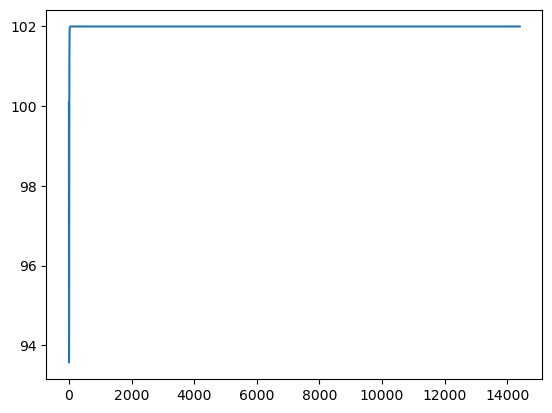

In [15]:
import matplotlib.pyplot as plt
plt.plot(V[:,0])

In [42]:
pd.DataFrame(sim_flow)

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,1668,1704,-1,1680,1968,1344,1380,-1,1368,1428,...,1932,1152,-1,1212,1284,1260,1368,1788,1764,1860
1,1668,1704,-1,1680,1968,1344,1380,-1,1368,1428,...,1932,1152,-1,1212,1284,1260,1368,1788,1764,1860
2,1668,1704,-1,1680,1968,1344,1380,-1,1368,1428,...,1932,1152,-1,1212,1284,1260,1368,1788,1764,1860
3,1668,1704,-1,1680,1968,1344,1380,-1,1368,1428,...,1932,1152,-1,1212,1284,1260,1368,1788,1764,1860
4,1668,1704,-1,1680,1968,1344,1380,-1,1368,1428,...,1932,1152,-1,1212,1284,1260,1368,1788,1764,1860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11515,2076,2088,-1,2016,2256,1620,1656,-1,1680,1836,...,1716,1500,-1,1392,1404,1392,1368,1716,1872,2064
11516,2076,2088,-1,2016,2256,1620,1656,-1,1680,1836,...,1716,1500,-1,1392,1404,1392,1368,1716,1872,2064
11517,2076,2088,-1,2016,2256,1620,1656,-1,1680,1836,...,1716,1500,-1,1392,1404,1392,1368,1716,1872,2064
11518,2076,2088,-1,2016,2256,1620,1656,-1,1680,1836,...,1716,1500,-1,1392,1404,1392,1368,1716,1872,2064
